# Setup Environment

In [1]:
# Install Open3d
!pip install open3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.1 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.4
    Uninstalling widgetsnbextension-3.6.4:
      Successfully uninstalled widgetsnbextension-3.6.4
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pi

In [2]:
# Import required library
import numpy as np
from matplotlib import pyplot as plt
import open3d as o3d
import yaml
from PIL import Image

## Create Point Cloud of Assymetric Building

In [3]:
# Define center of point cloud
pt_center = np.array([1, 2.5, 1, 2.5])

# Create array of Wall components
walls = np.array([[-9, 10, -9, -5],
                  [-9, -5, 11, -5],
                  [11, -5, 11,  0],
                  [11,  0,  6,  0],
                  [ 6,  0,  6,  5],
                  [ 6,  5, -4,  5],
                  [-4,  5, -4, 10],
                  [-4, 10, -9, 10]]) - pt_center


In [10]:
# Initialize point cloud variable
pts = []

# Define Point CLoud Resolution
points_res = 0.01

# Loop through each wall component
for wallNo in range(0, int(walls.shape[0])):

  # Calculate delta position per wall point
  delta = walls[wallNo][2:4]-walls[wallNo][0:2]
  size_side = (delta[0]**2 + delta[1]**2)**0.5
  num_pts = size_side/points_res
  delta_pos = delta/num_pts

  # Loop through each point in the wall
  for i in range(0, int(num_pts)+1):
    pt_new = walls[wallNo][0:2] + delta_pos*i;
    pt3D = np.array([pt_new[0], pt_new[1], 0])
    pts.append(pt3D)

pts = np.array(pts)

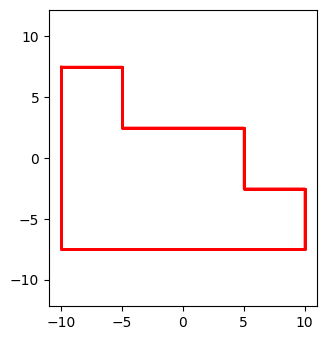

In [11]:
# Display results
plt.rcParams["figure.figsize"] = [3.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.plot(pts[:,0],pts[:,1], '*-', color='red', markersize=1)
plt.axis('equal')
plt.show()

In [12]:
# Save data to PCD file
sample_pcd_data = o3d.data.PCDPointCloud()
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts)
o3d.io.write_point_cloud("test_smaller.pcd", pcd)

[Open3D INFO] Downloading https://github.com/isl-org/open3d_downloads/releases/download/20220201-data/fragment.pcd
[Open3D INFO] Downloaded to /root/open3d_data/download/PCDPointCloud/fragment.pcd


True

## Create Occupancy Map

In [13]:
# Specify size and resolution of map
gridSizeMeters = 45
res = 5

# Calculate grid size and center location
gridSize = gridSizeMeters/res
center = np.array([(gridSize-1)/2, (gridSize-1)/2])

# Initialize Occupancy Map
occGrid = np.zeros((int(gridSize),int(gridSize),3), dtype=np.uint8)

# Loop through each point in point cloud
num_pts = pts.shape
for i in range(0, num_pts[0]):

  # Set location in Occupancy Map to occupied
  location = pts[i,:2]/res + center
  occGrid[int(location[0]),int(location[1])] = [255,255,255]

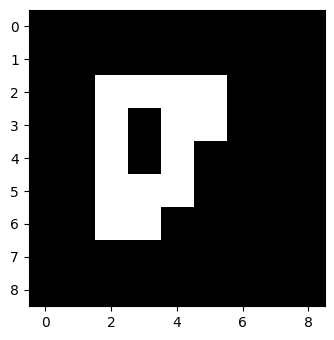

In [14]:
# Show Occupancy Map
plt.imshow(occGrid, interpolation='none')
plt.show()

In [15]:
# Create Occupancy Map YAML Strucutre
occupancy_grid = dict()
occupancy_grid['resolution'] = res
occupancy_grid['origin'] = [0.0, 0.0, 0.0]
occupancy_grid['negate'] = 0
occupancy_grid['occupied_thresh'] = 1.0
occupancy_grid['free_thresh'] = 0.0
occupancy_grid['image'] = 'occupancy_map.png'
occupancy_grid['mode'] = "trinary"

# Write Occupancy Map YAML
with open('occupancy_map.yaml', 'w') as fp:
    yaml.dump(occupancy_grid, fp)

# Save Occupancy Map image
img = Image.fromarray(occGrid)
img.save('occupancy_map.png')